# 1. 加载数据

In [81]:
import torch
import numpy as np

from numpy.linalg import pinv

import imageio
import matplotlib.pyplot as plt

name0 = ["lena"]
name = ["lena_mar"]
image = imageio.imread('./datasets/{}.bmp'.format(name0[0]))
sparse_image = imageio.imread('./datasets/{}.bmp'.format(name[0]))
sparse_mat = sparse_image[:, :, 1]
dense_mat = image[:, :, 1]

print(dense_mat.shape)

(256, 256)


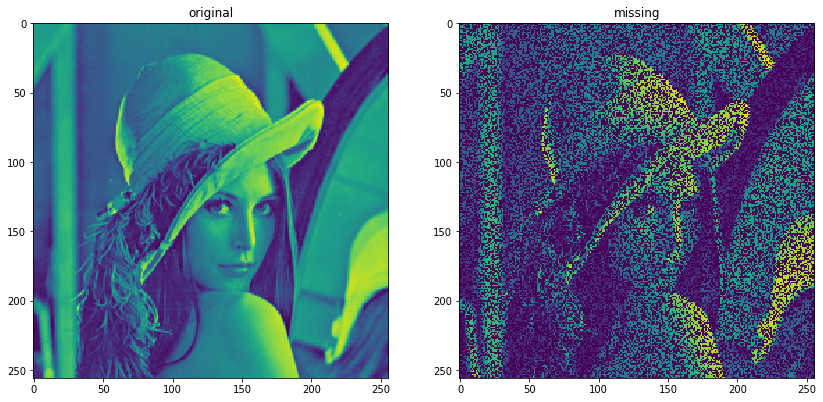

In [82]:
def PlotImages(*params):
    if len(params) == 2: 
        fig = plt.figure(figsize=(14,7))
        ax1 = fig.add_subplot(121)
        ax2 = fig.add_subplot(122)
        ax1.imshow(params[0])
        ax1.set_title('original')
        
        ax2.imshow(params[1])
        ax2.set_title('missing')
    
    elif len(params) == 3:
        fig = plt.figure(figsize=(21, 7))
        ax1 = fig.add_subplot(131)
        ax2 = fig.add_subplot(132)
        ax3 = fig.add_subplot(133)
        
        ax1.imshow(params[0])
        ax1.set_title('original')
        
        ax2.imshow(params[1])
        ax2.set_title('missing')
        
        ax3.imshow(params[2])
        ax3.set_title('prediction')
# ========================================

def Measurement(original, prediction, missing_index, verbose=True):
    # print(original.shape, prediction.shape)
    pred_error = original-prediction
    pred_error = pred_error[missing_index]
    ae = np.abs(pred_error)
    mae = np.mean(ae)
    mse = np.mean(ae*ae)
    # print(ae)
    if verbose:
        print('mae:{0:.4f}, mse:{1:.4f}'.format(mae, mse))
    return mae, mse
# ========================================
PlotImages(dense_mat, sparse_mat)

In [83]:
K       = 100
epoches = 100
verbose = 10
lr      = 0.01
beta    = 0.001  # 正则化系数

missing_value  = 0. # 缺失值标记

original_matrix = dense_mat.copy().astype(float)
missing_matrix = sparse_mat.copy().astype(float)
# 缺失值索引
missing_index  = np.where(missing_matrix == missing_value)
# 未缺失值索引
complete_index = np.where(missing_matrix != missing_value)
# print(complete_index[0].shape, missing_index[0].shape)

N = missing_matrix.shape[0]
D = missing_matrix.shape[1]

missing_matrix_nan = missing_matrix.copy()
missing_matrix_nan[missing_matrix_nan == missing_value] = np.nan
mu = np.nanmean(missing_matrix_nan, axis=0)
print('mu:', mu.shape)
# print(np.mean(missing_matrix, axis=1))

W = np.random.randn(D, K)
# print('W:', W.shape)
I = np.eye(K, K)
# print('I:', I.shape)
sigmoid = np.random.randn()


Y = missing_matrix.copy()
print('Y[[0]]:', Y[[0]].shape)


def CalcuS(Y, mu):
    S = np.zeros((D, D))
    for i in range(N):
        S = S + np.dot(Y[i]-mu, (Y[i]-mu).T)
    S = S / N
    return S

all_losses = []
for epoch in range(epoches):
    M = np.dot(W.T, W) + sigmoid * I
    # print('M:', M.shape)
    
    C = np.dot(pinv(M), W.T)
    # print('C:', C.shape)
#     for i in range(N):
#         Y_i = Y[[i]].T
#         print('Y_i:', Y_i.shape)
    # print((Y-mu).shape)
    for i in range(N):
        # print(np.dot(C, (Y[0]-mu).T).shape)
        # print(np.dot(W, np.dot(C, (Y[0]-mu).T)).shape)
        Y[i] = np.dot(W, np.dot(C, Y[i]-mu)) + mu
    # Y[0] = np.dot(W, np.dot(C, (Y[0]-mu).T)) + mu.T
    # print('Y:', Y.shape)
    # W = 
    S = CalcuS(Y, mu)
    # print('S', S.shape)
    
    W = np.dot(np.dot(S, W), pinv(sigmoid * I + np.dot(np.dot(np.dot(pinv(M), W.T), S), W)))
    # print('W', W.shape)
    
    sigmoid = 1/D * np.trace(S - np.dot(np.dot(np.dot(S, W), pinv(M)), W.T))
    
    Y[complete_index] = sparse_mat[complete_index]
    
    all_losses.append(Measurement(original_matrix, Y, missing_index, verbose=False))
    if epoch % verbose == 0:
        print(epoch, end=':')
        Measurement(original_matrix, Y, missing_index)

mu: (256,)
Y[[0]]: (1, 256)
0:mae:58.1350, mse:5159.9500
10:mae:35.8318, mse:2109.3257
20:mae:35.8318, mse:2109.3257
30:mae:35.8318, mse:2109.3257
40:mae:35.8318, mse:2109.3257
50:mae:35.8318, mse:2109.3257
60:mae:35.8318, mse:2109.3257
70:mae:35.8318, mse:2109.3257
80:mae:35.8318, mse:2109.3257
90:mae:35.8318, mse:2109.3257


mae:35.8318, mse:2109.3257
mae:99.4247, mse:12596.7298


(99.42467185146475, 12596.72976545449)

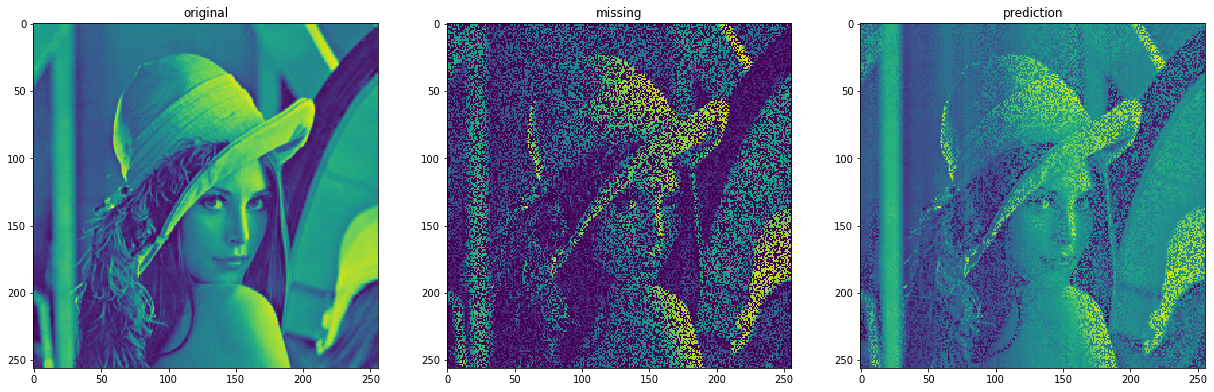

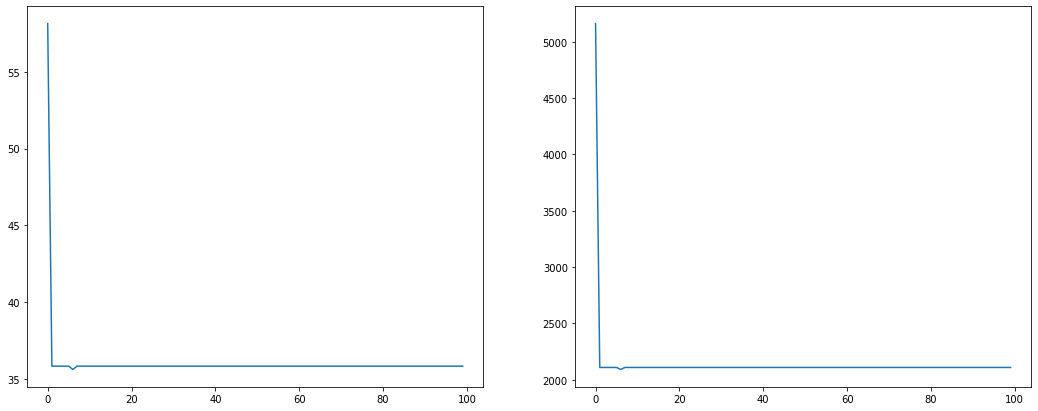

In [84]:
                      
matrix_predict = Y.copy()
matrix_predict[complete_index] = sparse_mat[complete_index]
PlotImages(dense_mat, sparse_mat, matrix_predict)

fig = plt.figure(2, figsize=(18, 7))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot([i[0] for i in all_losses])
ax2.plot([i[1] for i in all_losses])

Measurement(original_matrix, matrix_predict, missing_index)
Measurement(original_matrix, missing_matrix, missing_index)